In [29]:
## RUN THIS FIRST: Sets everything up
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#Just solving for the collision time between pairs of particles that are next to each other
def coll_time(par1, par2):
    b=par1.v-par2.v
    a=1/2*(par1.a-par2.a)
    c=par1.p-par2.p

    #This just makes it so the "-sqrt" root is always the smaller one
    if a<0:
        a=-1*a
        b=-1*b
        c=-1*c
    if b**2-4*a*c<0:
        return -1
    else:
        t=(-b-math.sqrt(b**2-4*a*c))/(2*a)
        if t>0:
            return t
        elif (-b+math.sqrt(b**2-4*a*c))/(2*a)>0:
            return (-b+math.sqrt(b**2-4*a*c))/(2*a)
        else:
            return -1


class Particle:
    def __init__(self, m, p, v, a):
        self.m=m
        self.p=p
        self.v=v
        self.a=a
    def posatt(self, t):
        return self.p+t*self.v+t**2/2*self.a
    def velatt(self, t):
        return self.v+t*self.a
    def posfunc(self, t):
        return self.p+t*self.v+(t**2)/2*self.a


def new_part(particlelist, t):
    pos0=particlelist[0].posatt(t)
    totalmom=0
    totalmass=0
    for i in particlelist:
        # NOTE: Probably need to add in margin of numerical error or something
        if abs(i.posatt(t)-pos0)>1*10**(-11):
            raise ValueError("Particles do not all collide at time t")
        totalmom+=i.velatt(t)*i.m
        totalmass+=i.m
    newvel=totalmom/totalmass
    return Particle(totalmass, pos0, newvel, 0)

In [30]:
### RUN THIS SECOND: This runs the actual simulation and stores the data in the list snapshots

# Choose origlist/make your own here for what you want to simulate.
# Particles(mass, position, velocity, acceleration).
# Masses will be reordered and accelerations recalculated

#origlist=[Particle(1/2, 1, -1, 0), Particle(1/2, -1, 1, 0)]
#origlist=[Particle(1/10, -8, 809/80, 0), Particle(1/10, -5, 327/80, 0), Particle(1/10, -4, 33/16, 0), Particle(1/10, -3, 3/80, 0), Particle(1/10, -1, 161/80, 0), Particle(1/10, 1, -161/80, 0), Particle(1/10, 3, -163/80, 0), Particle(1/10, 4, -65/16, 0), Particle(1/10, 5, -487/80, 0), Particle(1/10, 8, -329/80, 0)]
#origlist=[Particle(1/2, 1, 0, 0), Particle(1/2, -1, 0, 0)]
#origlist=[Particle(1/3, -3, math.sqrt(2), 0), Particle(1/3, 1, 0, 0), Particle(1/3, 2, -math.sqrt(2), 0)]
#origlist=[Particle(1/7, -3, 23, 0), Particle(1/7, -2, 2, 0), Particle(5/7, 1, -5, 0)]
#origlist=[Particle(1/4, -85/4, 4, 0), Particle(1/4, 15/4, 0, 0), Particle(1/2, 35/4, -2, 0)]
#origlist=[Particle(1/4, -85/4, 3.9921798556678274, 0), Particle(1/4, 13/4, 0.05371069193040334, 0), Particle(1/2, 36/4, -2.0229452737991165, 0)]
origlist=[Particle(0.8, -1.8, 0.5999885682712192, 0), Particle(0.1, 8-1.8, -2.0832930047285285, 0), Particle(0.1, 10-1.8, -2.7166155414412247, 0)]

# Function for use later
def pos(lst):
        return [x for x in lst if x > 0] or None

# Check that COM=0, momentum=0, mass=1
if abs(sum(j.m for j in origlist)-1)>10**-11:
    raise ValueError("Masses do not sum to 1")
elif abs(sum(j.m*j.p for j in origlist))>10**-11:
    raise ValueError("Center of Mass is not 0")
elif abs(sum(j.m*j.v for j in origlist))>10**-11:
    raise ValueError("Total momentum is not 0")

# Snapshots is where the data from the simulation will be stored
snapshots=[]

#Calculating the initial kinetic and potential energy
kinen=sum(j.m*j.v**2 for j in origlist)
poten=1/2*sum(sum(abs(j.p-k.p)*j.m*k.m for k in origlist) for j in origlist)

# Reordering the masses and calculating the number of particles we have
newlist=sorted(origlist, key=lambda x: x.p)
numparts=len(newlist)

#Beginning the actual simulation
while numparts>1:
    # Colltimes[i] is the collision time between particle i and particle i+1 if it exists or -1 if it does not exist
    colltimes=[]

    #Recalculating accelerations and also populating collision times
    newlist[0].a=-1/2*sum(j.m for j in newlist[1:])
    for i in range (1, len(newlist)):
        newlist[i].a=1/2*(sum(j.m for j in newlist[0:i])-sum(j.m for j in newlist[i+1:]))
        colltimes.append(coll_time(newlist[i-1], newlist[i]))

    #Adding in the initial state to the snapshot if we're in the initial state
    if not snapshots:
        snapshots.append((0, tuple(newlist), kinen, poten))

    #Taking only the actual collision times
    postimes=pos(colltimes)



    #If there are no more collisions, the while loop ends (even if the number of particles is still >1
    if not postimes:
        break

    # Gathering all the particles that collide at the first collision time (even if they don't all collide together)
    mintime=min(postimes)
    indices = [i for i, v in enumerate(colltimes) if abs(v-mintime)<1*10**-11]
    ranges=[]


    # Finding the range of particles that all collide together (i.e. if the first collision is between particles 1-3 then ranges[0] will capture that
    k=0
    j=0
    while k+j<len(indices):
        while k+j<len(indices) and indices[k+j]==indices[k]+j:
            j+=1
        ranges.append([indices[k], indices[k+j-1]])
        k+=j
        j=0


    # Calculating the new colliding particle and noting which particles have collided
    newnewlist=[]
    usedlist=[]
    for i in ranges:
        startrange=i[0]
        endrange=i[1]
        collparts=[]
        for j in range(startrange, endrange+2):
            collparts.append(newlist[j])
            usedlist.append(j)
        newnewlist.append(new_part(collparts, mintime))

    #Adding in particles that weren't in the collision and updating their positions and velocities
    for i in range(len(newlist)):
        if i not in usedlist:
            newnewlist.append(Particle(newlist[i].m, newlist[i].p, newlist[i].v, newlist[i].a))
            newnewlist[-1].p=newlist[i].posatt(mintime)
            newnewlist[-1].v=newlist[i].velatt(mintime)

    #Sorting our list of particles and recalculating the number
    newlist=sorted(newnewlist, key=lambda x: x.p)
    numparts=len(newlist)

    #Recalculating kinetic and potential energy
    kinen=sum(j.m*j.v**2 for j in newlist)
    poten=1/2*sum(sum(abs(j.p-k.p)*j.m*k.m for k in newlist) for j in newlist)

    #Adding all this information to the snapshot before we repeat
    prevtime=snapshots[-1][0]
    snapshots.append((mintime+prevtime, tuple(newlist), kinen, poten))


snapshots

[(0,
  (<__main__.Particle at 0x187aaaa6330>,
   <__main__.Particle at 0x187aaa54140>),
  1.46,
  1.4600000000000002),
 (6.001949725371531,
  (<__main__.Particle at 0x187aaa56030>, <__main__.Particle at 0x187aaa57fb0>),
  1.7041088398292448e-07,
  5.504218629454272e-05)]

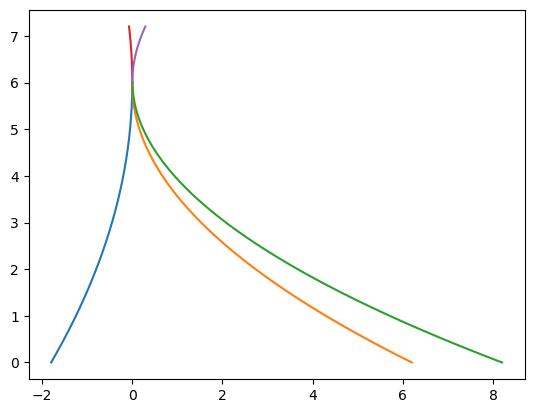

In [31]:
## RUN THIS THIRD: This does the graphing

#Distributing points properly
barometer=snapshots[-1][0]*1.2
if barometer>0:

    #Plotting for each of the times between collisions
    for i in range(0, len(snapshots)-1):
        tstart=snapshots[i][0]
        tend=snapshots[i+1][0]
        numpoints=round((tend-tstart)/barometer*1000)
        yvals=np.linspace(tstart, tend, numpoints)
        for j in snapshots[i][1]:
            #Note here we just have to make an adjustment based on the time, but otherwise it's just kinematics
            xvals=j.p+(yvals-tstart)*j.v+j.a/2*(yvals-tstart)**2
            plt.plot(xvals, yvals)

    #Plotting for the time after collision
    tstart=snapshots[-1][0]
    tend=tstart*1.2
    numpoints=round((tend-tstart)/barometer*1000)
    yvals=np.linspace(tstart, tend, numpoints)
    for j in snapshots[-1][1]:
        xvals=j.p+(yvals-tstart)*j.v+j.a/2*(yvals-tstart)**2
        plt.plot(xvals, yvals)

#Plot if there are no collisions
else:
    tstart=0
    tend=25
    numpoints=1000
    yvals=np.linspace(tstart, tend, numpoints)
    for j in snapshots[-1][1]:
        xvals=j.p+(yvals-tstart)*j.v+j.a/2*(yvals-tstart)**2
        plt.plot(xvals, yvals)